In [204]:
import tensorflow as tf
import tensorflow_lattice as tfl
import tf_keras as keras
import numpy as np

lattice_sizes = [2]
combined_calibrators = tfl.layers.ParallelCombination()

# ############### age ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(0, 1, num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
    monotonicity='increasing'
)
combined_calibrators.append(calibrator)


lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing'
    ],
    output_min=0,
    output_max=5)

model = keras.models.Sequential()
model.add(calibrator)
model.add(lattice)
model.add(keras.layers.Dense(3, activation='linear'))



In [205]:
# def custom_loss(y_true, y_pred):
#     # Compute mean squared error as the base loss
#     base_loss = tf.reduce_mean(tf.square(y_true - y_pred))

#     # Add monotonicity penalty between outputs
#     monotonicity_penalty = 0

#     # Combine the base loss and the penalty
#     total_loss = base_loss + monotonicity_penalty
#     return total_loss

from tensorflow.keras import backend as K

def QuantileLoss(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(y <= pred, tf.float32)
        d = K.abs(y - pred)
        correction = I * (1 - perc) + (1 - I) * perc
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.maximum(0.0, pred[:, :-1] - pred[:, 1:] + 1e-6), -1)
        return huber_loss + q_order_loss
    return _qloss



In [214]:
xTrain = np.random.uniform(0,1,size=5000)
yTrain = np.array([x*2+ np.random.uniform(low=-x, high = x) for x in xTrain])

In [215]:
features = xTrain.reshape(-1,1).astype(np.float32)
target = yTrain.reshape(-1,1).astype(np.float32)
perc_points = [0.25, 0.5, 0.75]

model.compile(
    loss=QuantileLoss(perc_points),#keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01))
model.fit(
    features,
    target,
    epochs=500,
    validation_split=0.2,
    shuffle=False,
    verbose=0)

model.evaluate(features, target)

157/157 [==============================] - 0s 1ms/step - loss: 0.3068


0.30680975317955017

4/4 [==============================] - 0s 2ms/step


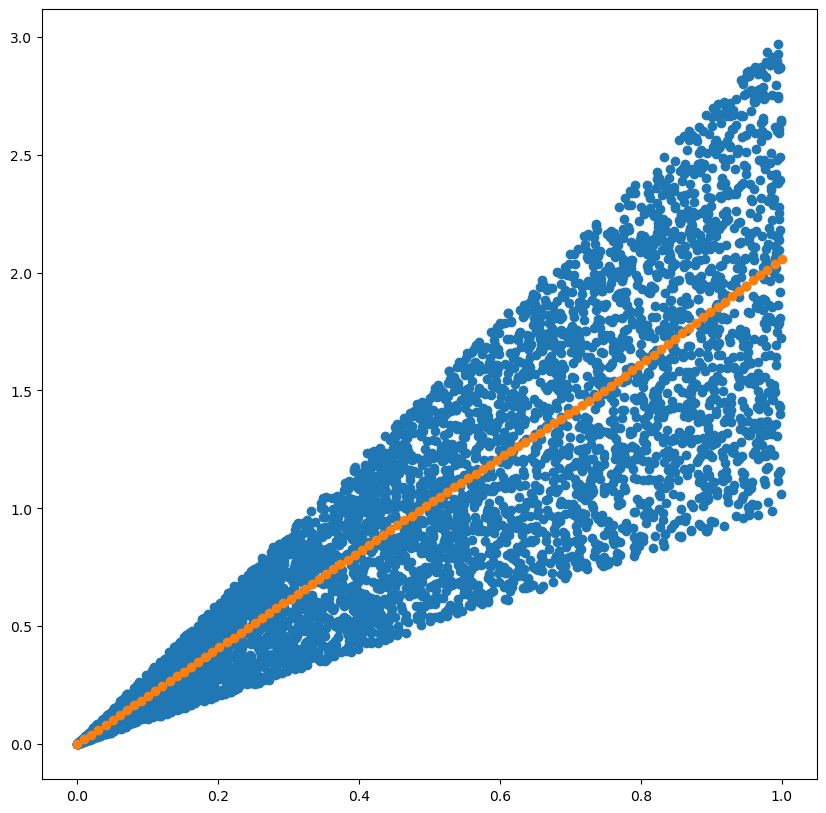

In [217]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,10))

# xTrain = np.random.uniform(0,1,size=1000)
# yTrain = np.array([x*2.5 + np.random.uniform(low=-x, high = x) for x in xTrain])

xWant = np.linspace(0,1,100).reshape(-1,1)
yPred = model.predict(xWant)

ax.scatter(xTrain, yTrain)
ax.scatter(xWant, yPred[:,1])